# Homework #6: Decision Trees and Random Forests

A bank is interested in reaching out to customers directly (via phone) to solicit subscriptions to a new product they are planning to offer. The company has over 45k customers and only a small number of phone agents to contact them so targeting those that are most likely to subscribe will maximize their return on investment.

Prior to contacting them, they have asked their Data Science team to analyze customer characteristics for a similar product campaign they ran in the previous year. Your goal is to construct an effective tree-based model to predict whether a customer will subscribe or not.

### Relevant Dataset
`bank-full.csv`
* Response Variable: `y`

### Source of data: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

## Task 1: Import data and construct a random 70/15/15 train/val/test split. Make sure to dummy code categorical variables.

In [37]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_blobs, make_circles, make_classification, fetch_olivetti_faces
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
from statistics import mode

%matplotlib inline

In [2]:
def plot_decision_boundary(X, y, clf):
    x0_mesh, x1_mesh = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, 0.1),
                                 np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, 0.1))

    y_mesh_pred = clf.predict(np.c_[x0_mesh.ravel(), x1_mesh.ravel()])
    y_mesh_pred = y_mesh_pred.reshape(x0_mesh.shape)

    plt.contourf(x0_mesh, x1_mesh, y_mesh_pred, cmap="RdBu", vmin=0, vmax=1)
    plt.scatter(X[:, 0], X[:, 1], c = y, s = 50, edgecolor = 'w', cmap="RdBu", vmin=-.2, vmax=1.2, linewidth=1)
    plt.show()

In [3]:
df = pd.read_csv('bank-full.csv', sep=";")
df = df.dropna()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
X = df.drop(['y'],axis=1)
X = pd.get_dummies(data=X, drop_first=True)
y = df.y
y = pd.get_dummies(data=y, drop_first=True)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=50)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(31647, 42) (31647, 1)
(6782, 42) (6782, 1)
(6782, 42) (6782, 1)


In [5]:
X

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
45207,71,1729,17,456,2,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
45208,72,5715,17,1127,5,184,3,0,0,0,...,0,0,0,0,1,0,0,0,1,0
45209,57,668,17,508,4,-1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


## Task 2: Use Cost-Complexity Pruning to find the optimal depth for a Decision Tree Classifier.

Note: "Optimal" is subjective. Feel free to choose a shallower more interpretable tree or a slightly deeper more accurate tree. Simply explain why you chose the depth you did.

In [6]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
train_acc = clf.score(X_train,y_train)
val_acc = clf.score(X_val, y_val)

print(f'Training Accuracy: {train_acc}')
print(f'Test Accuracy: {val_acc}')
# plot_decision_boundary(X_test,y_val,clf)

Training Accuracy: 1.0
Test Accuracy: 0.8764376290179888


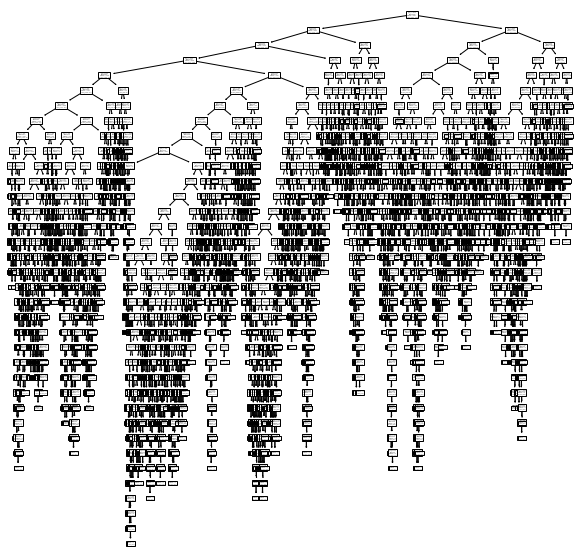

In [7]:
plt.figure(figsize=(10, 10))
plot_tree(clf)
plt.show()

Text(0, 0.5, 'total impurity of leaves')

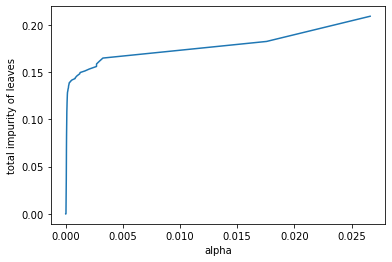

In [8]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.plot(ccp_alphas, impurities)
plt.xlabel("alpha")
plt.ylabel("total impurity of leaves")

Text(0, 0.5, 'total depth')

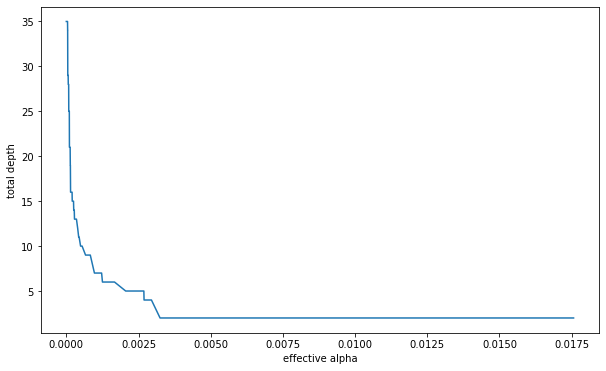

In [9]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

Text(0, 0.5, 'Accuracy scores')

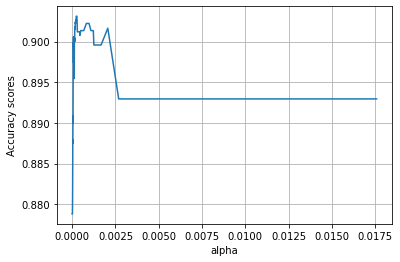

In [10]:
acc_scores = [clf.score(X_val, y_val) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("alpha")
plt.ylabel("Accuracy scores")

In [11]:
optimal_clf = clfs[np.argmax(acc_scores)]

train_acc = clf.score(X_train,y_train)
test_acc = clf.score(X_test, y_test)

print(f'Training Accuracy: {train_acc}')
print(f'Test Accuracy: {test_acc}')

# plot_decision_boundary(X_test,y_test,optimal_clf)

Training Accuracy: 0.8815053559579107
Test Accuracy: 0.8876437629017989


## Task 3: Visualize the "Optimal" tree you fit and interpret the first few splits to the best of your ability.

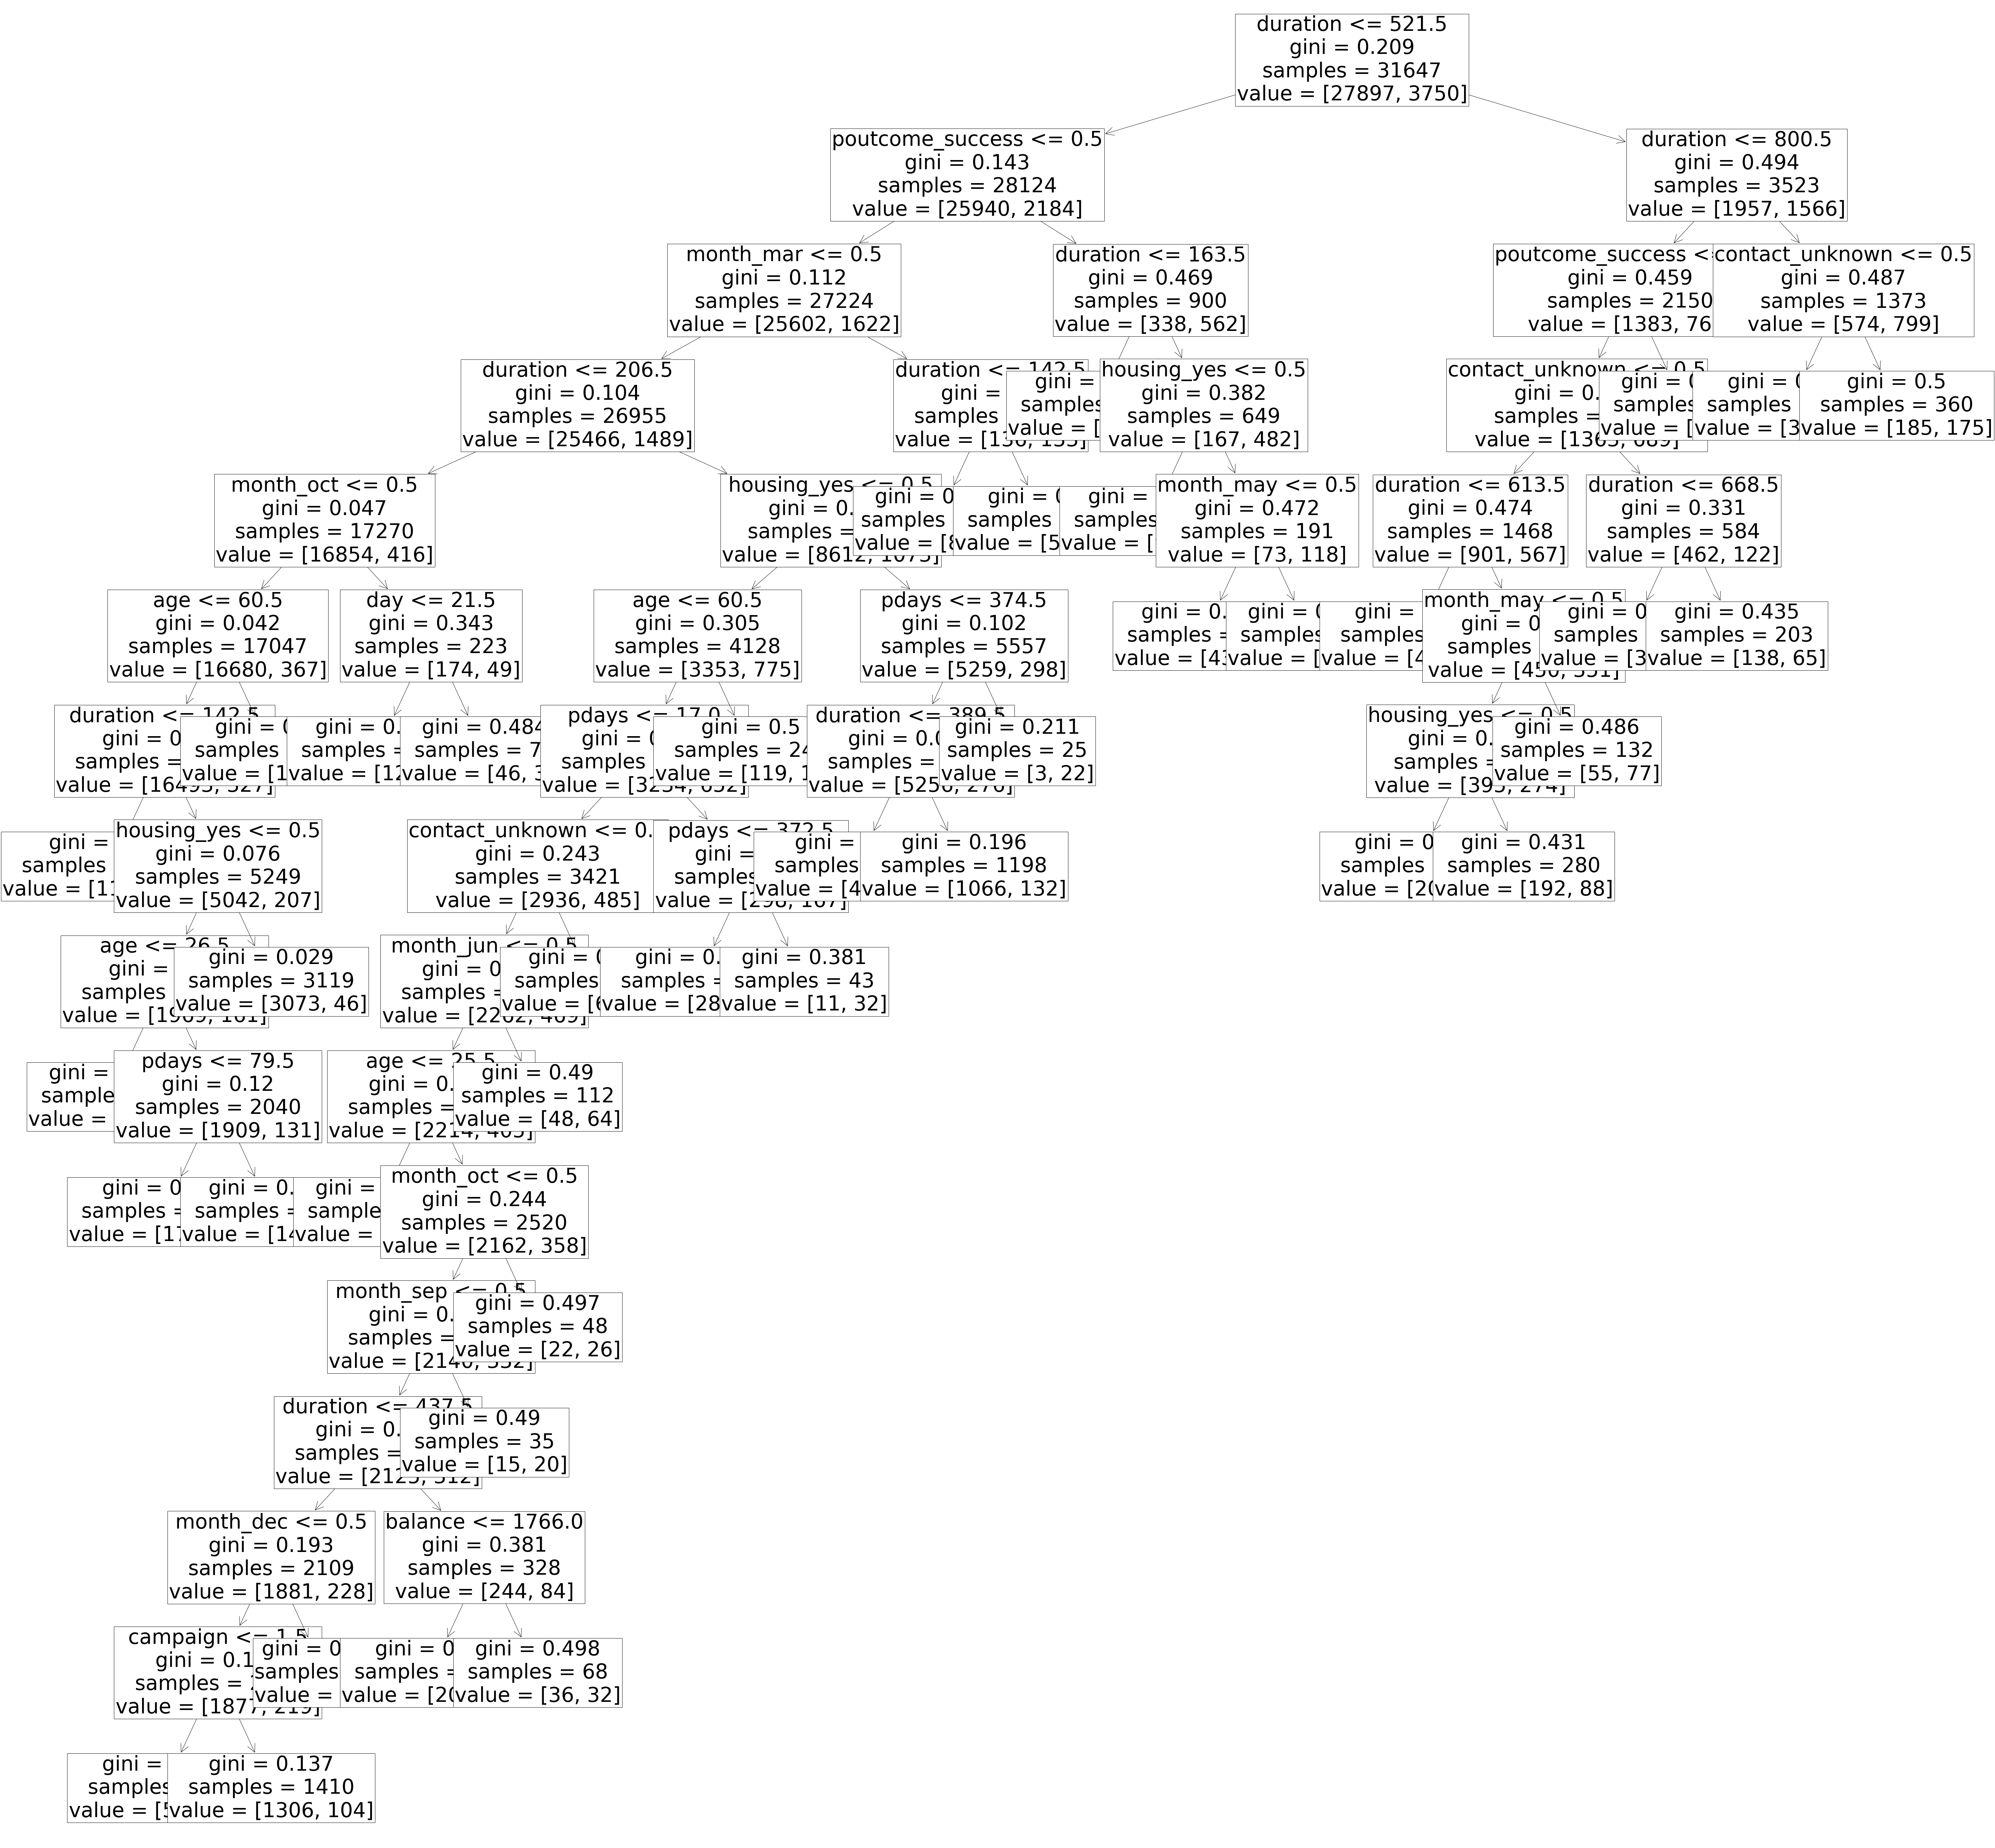

In [12]:
plt.figure(figsize=(100, 100))
plot_tree(optimal_clf, feature_names=X.columns, fontsize=60)
plt.show()

Is the duration less or greater than 521.5. Is it greater than 800.5?
Was the last campaign successful?

## Task 4: Calculate the k-fold CV accuracy for predicting 'yes' or 'no' using a Decision Tree Classifier.

In [20]:
acc_lst = []
folds = np.random.randint(0,10,X_train.shape[0])

for i in range(10):
    train_fold_x = X_train[folds != i]
    train_fold_y = np.array(y_train[folds != i])
    val_fold_x = X_train[folds == i]
    val_fold_y = np.array(y_train[folds == i])
    
    clf = DecisionTreeClassifier().fit(train_fold_x, train_fold_y)
    
    val_acc = optimal_clf.score(val_fold_x, val_fold_y)
    print(f'val Accuracy: {test_acc}')
    acc_lst.append(val_acc)
    
acc_lst = np.stack(acc_lst)

val Accuracy: 0.8876437629017989
val Accuracy: 0.8876437629017989
val Accuracy: 0.8876437629017989
val Accuracy: 0.8876437629017989
val Accuracy: 0.8876437629017989
val Accuracy: 0.8876437629017989
val Accuracy: 0.8876437629017989
val Accuracy: 0.8876437629017989
val Accuracy: 0.8876437629017989
val Accuracy: 0.8876437629017989


In [ ]:
bin_pred_list = []
yval_list = []
for i in range(10):
    val = hr_train_val.iloc[np.where(folds == i)[0],:]
    train = hr_train_val.iloc[np.where(folds != i)[0],:]

    Xtrain = train[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
    ytrain = train[['Attrition']]
    Xtrain = sm.add_constant(Xtrain)
    log_reg = sm.Logit(ytrain, Xtrain).fit()

    Xval = val[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
    yval = val[['Attrition']]
    Xval = sm.add_constant(Xval, has_constant='add')
    val_preds = log_reg.predict(Xval.apply(pd.to_numeric))

    binary_preds = np.where(val_preds >= thresh, 1, 0)
    bin_pred_list.extend(binary_preds)
    yval_list.extend(yval['Attrition'].tolist())
acc_list.append(accuracy_score(yval_list, bin_pred_list))

In [21]:
np.mean(acc_lst)

0.9059588146752718

In [16]:
np.mean(acc_list)

0.9059958213952488

## Task 5: Fit a Random Forest Classifier and use the OOB accuracy to choose the optimal number of trees and/or variables sampled at each split.

Note: The argument for number of trees is `n_estimators` in scikit-learn and the number of variables to consider at each split is `max_features`.

In [22]:
clf = RandomForestClassifier(n_estimators=100,
                            max_depth=None,
                            oob_score=True,
                            random_state=21)
clf.fit(X_train,y_train)

<ipython-input-22-f5b7f0619d31>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


RandomForestClassifier(oob_score=True, random_state=21)

<ipython-input-32-75365395ec25>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)
C:\Users\light\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
<ipython-input-32-75365395ec25>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)
C:\Users\light\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
<ipython-input-32-75365395ec25>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

[0.8790117449293313, 0.8925040366282542, 0.90086483377939, 0.9041604919156843, 0.9067925947225233, 0.9057751432173586, 0.9061290393930681]


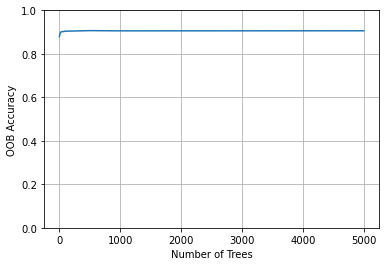

In [32]:
n_trees = [1,10,25,100,500,1000,5000]

oob_acc = []
for n in n_trees:
    clf = RandomForestClassifier(n_estimators=n,
                                 max_depth=None,
                                 max_features=25,
                                 oob_score=True)
    clf.fit(X,y)
    oob_acc.append(clf.oob_score_)

plt.grid()
plt.ylim([0, 1.0])
plt.plot(n_trees, oob_acc)
plt.xlabel("Number of Trees")
plt.ylabel("OOB Accuracy")
print(oob_acc)

500 trees is optimal

<ipython-input-33-f8bd655fd8b9>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)
<ipython-input-33-f8bd655fd8b9>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)
<ipython-input-33-f8bd655fd8b9>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)
<ipython-input-33-f8bd655fd8b9>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X,y)
<ipython-input-33-f8bd655fd8b9>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using

[0.8996040786534251, 0.9059520913052134, 0.9050673508659397, 0.9030324478556103, 0.9047798102231758, 0.9045807436243392]


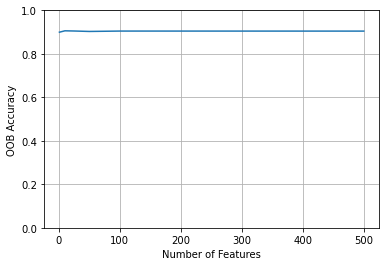

In [33]:
n_features_per_split = [1,10,25,50,100,500]

oob_acc = []
for n in n_features_per_split:
    clf = RandomForestClassifier(n_estimators=100,
                                 max_depth=None,
                                 max_features=n,
                                 oob_score=True)
    clf.fit(X,y)
    oob_acc.append(clf.oob_score_)

plt.grid()
plt.ylim([0, 1.0])
plt.plot(n_features_per_split, oob_acc)
plt.xlabel("Number of Features")
plt.ylabel("OOB Accuracy")
print(oob_acc)

10 features is optimal

## Task 6: Report impurity based feature importance for your final selected model in a bar chart. 

Optional: If you are curious, try running permutation importance (note: this may take a while) and compare the two

In [25]:
clf.feature_importances_

array([0.09762885, 0.09963302, 0.08545878, 0.27331102, 0.03935855,
       0.04036231, 0.02043047, 0.00900635, 0.00359728, 0.00350715,
       0.01048369, 0.00551874, 0.00482163, 0.00629393, 0.00510704,
       0.01148914, 0.00513665, 0.00126454, 0.01213636, 0.00978618,
       0.01344361, 0.01170202, 0.00552086, 0.00172349, 0.02069068,
       0.01019562, 0.00696577, 0.01395325, 0.01065519, 0.00410697,
       0.00813821, 0.00602624, 0.00955463, 0.01155963, 0.01527808,
       0.01112867, 0.00872097, 0.01129308, 0.00797964, 0.00385123,
       0.05521739, 0.00796311])

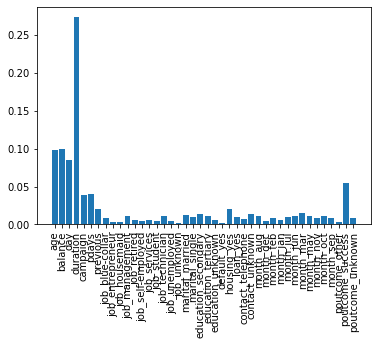

In [30]:
plt.bar(x=X.columns,height=clf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

In [31]:
cv_perm_imp = []
folds = np.random.randint(0,10,X_train.shape[0])

for i in range(10):
    train_fold_x = X_train[folds != i]
    train_fold_y = y_train[folds != i]
    val_fold_x = X_train[folds == i]
    val_fold_y = y_train[folds == i]
    
    clf = RandomForestClassifier().fit(train_fold_x, train_fold_y)
    
    perm_imp = permutation_importance(clf, val_fold_x, val_fold_y, n_repeats = 30, random_state=24)
    cv_perm_imp.append(perm_imp['importances_mean'])

cv_perm_imp = np.stack(cv_perm_imp)

<ipython-input-31-b69f991b5944>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = RandomForestClassifier().fit(train_fold_x, train_fold_y)
<ipython-input-31-b69f991b5944>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = RandomForestClassifier().fit(train_fold_x, train_fold_y)
<ipython-input-31-b69f991b5944>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = RandomForestClassifier().fit(train_fold_x, train_fold_y)
<ipython-input-31-b69f991b5944>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = RandomForestClassifier().fit(trai

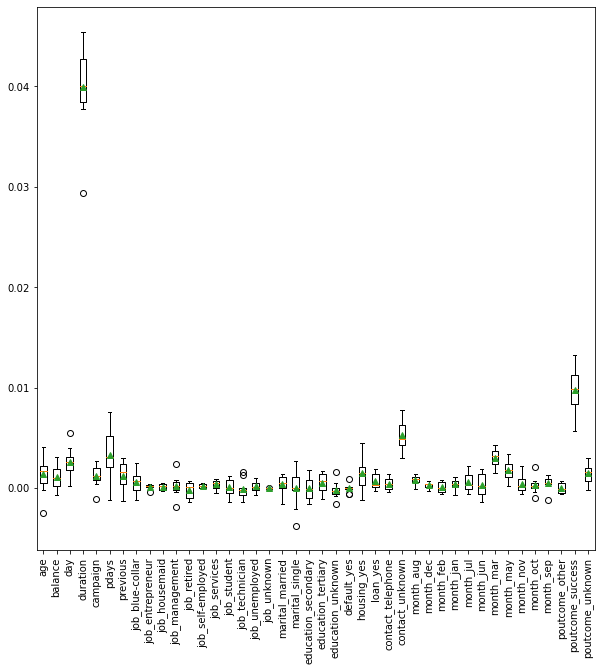

In [34]:
plt.figure(figsize=(10, 10))
plt.boxplot(cv_perm_imp, labels = X.columns, showmeans=True)
plt.xticks(rotation = 90)
plt.show()

## Task 7: Choose the model with the best cross-validated or OOB accuracy between Decision Trees and Random Forests and provide the Partial Dependence Plots for the 5 most important variables.

In [36]:
clf.oob_score_

0.9045807436243392

The Random Forest's oob score is greater than the cv accuracy of the decision tree.

In [42]:
forest = RandomForestClassifier(n_estimators=500,
                            max_depth=None,
                            oob_score=True,
                            random_state=21,
                            max_features=10)

forest.fit(X_train, y_train)

<ipython-input-42-180944c20a9a>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_features=10, n_estimators=500, oob_score=True,
                       random_state=21)

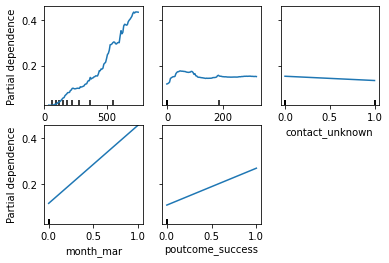

In [44]:
features = [3,5,27,34,40]
PartialDependenceDisplay.from_estimator(forest, X_train, features)